<a href="https://colab.research.google.com/github/MaulanaHasyim/MaulanaHasyim/blob/main/notebooks/kode_crawling_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.8 MB/s eta 0:00:00


In [12]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.0 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
import string
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aunanya875/suicidal-tweet-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 88.3k/88.3k [00:00<00:00, 41.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aunanya875/suicidal-tweet-detection-dataset/versions/1


In [15]:
import os
print(os.listdir('../root/.cache/kagglehub/datasets/aunanya875/suicidal-tweet-detection-dataset/versions/1'))

['Suicide_Ideation_Dataset(Twitter-based).csv']


In [16]:
df = pd.read_csv(".."+path+"/Suicide_Ideation_Dataset(Twitter-based).csv")
df

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post
1783,Starting my day out with a positive attitude! ...,Not Suicide post
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post
1785,2 drunken besties stumble into my room and we ...,Not Suicide post


In [17]:
df.shape

(1787, 2)

In [18]:
print("Jumlah data duplikat", df.duplicated(subset="Tweet").sum())
print("Jumlah data kosong", df.isnull().sum().sum())

Jumlah data duplikat 9
Jumlah data kosong 2


In [19]:
df.loc[df.duplicated(subset="Tweet")]

,Tweet,Suicide
432,Became as hot as the persistent days resting h...,Potential Suicide post
749,RT @MileyCyrus: Completely devestated by the f...,Not Suicide post
1006,RT @palestinianho: patient: i hate myself and ...,Potential Suicide post
1017,NaN,Not Suicide post
1173,AFTER EFFECTS HAS FROZEN AND I DID NOT I REPEA...,Potential Suicide post
1354,RT @NiallOfficial: 2 wins in 2 weeks . Congrat...,Not Suicide post
1362,I hate myself,Potential Suicide post
1458,@jessedonoe I mean.... my life is miserable so...,Potential Suicide post
1643,"Wait I take this back, I fucking hate living i...",Potential Suicide post


In [20]:
# Sample data duplicate
df.loc[df['Tweet'] == "I hate myself"]

,Tweet,Suicide
662,I hate myself,Potential Suicide post
1362,I hate myself,Potential Suicide post


In [21]:
# Drop data duplikat dan data kosong
df.drop_duplicates(subset="Tweet", inplace=True)
df.dropna(inplace=True)

In [22]:
print("Jumlah data duplikat", df.duplicated(subset="Tweet").sum())
print("Jumlah data kosong", df.isnull().sum().sum())

Jumlah data duplikat 0
Jumlah data kosong 0


In [23]:
# distribusi data Suicide
value_counts = df['Suicide'].value_counts(normalize=True) * 100
categories = value_counts.index
percentages = value_counts.values

<ipython-input-24-bd0439804e09>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=percentages, palette="pastel", ax=axes[1])


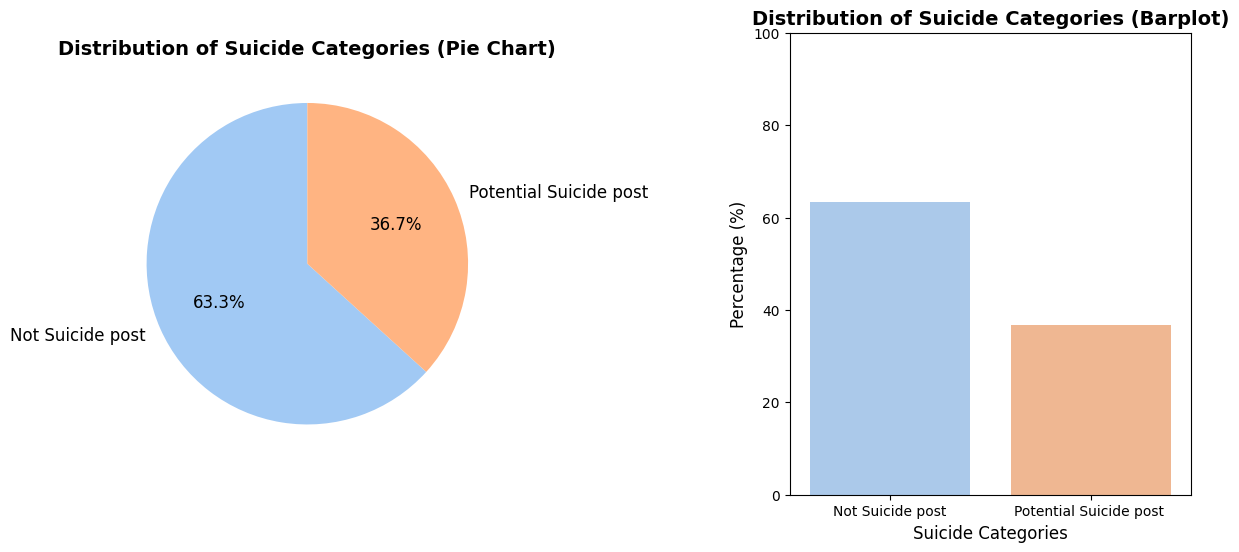

In [24]:
# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 baris, 2 kolom
plt.subplots_adjust(wspace=0.7)

colors = sns.color_palette("pastel")
axes[0].pie(percentages, labels=categories, autopct='%.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title("Distribution of Suicide Categories (Pie Chart)", fontsize=14, weight='bold')

sns.barplot(x=categories, y=percentages, palette="pastel", ax=axes[1])
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_xlabel("Suicide Categories", fontsize=12)
axes[1].set_title("Distribution of Suicide Categories (Barplot)", fontsize=14, weight='bold')
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', labelsize=10)

plt.show()


In [25]:
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


In [26]:
# Kamus kata
slang_dict = {
    "u": "you",
    "omg": "oh my god",
    "bff": "best friend forever",
    "gonna": "going to",
    "wanna": "want to",
    "idk": "i don't know",
    "brb": "be right back",
    # Nanti ditambah
}

In [27]:
def normalize_text(text):
  text = text.lower()
  text = emoji.demojize(text)
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'rt[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)
  text = re.sub(r'[^A-Za-z0-9\' ]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()

  # Normalisasi slang
  words = text.split()
  normalized_words = [slang_dict[word] if word in slang_dict else word for word in words]

  return ' '.join(normalized_words)

In [28]:
# Contoh hasil dari clean text
print(normalize_text("RT @user: I'm sure this is a test for u! Check http://example.com #example 😊"))

i'm sure this is a test for you check smilingfacewithsmilingeyes


In [29]:
# Clean twitter text
df['Tweet'] = df['Tweet'].apply(normalize_text)
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,you want his money,Not Suicide post
2,that crap took me forever to put together im g...,Potential Suicide post
3,hey jer since when did you statwittering,Not Suicide post
4,trying out quotdelicious library 2quot with mi...,Not Suicide post


In [30]:

# Tokenized text
df['Clean_Tweet'] = df['Tweet'].apply(word_tokenize)

df[['Tweet', 'Clean_Tweet']].head()

,Tweet,Clean_Tweet
0,making some lunch,"[making, some, lunch]"
1,you want his money,"[you, want, his, money]"
2,that crap took me forever to put together im g...,"[that, crap, took, me, forever, to, put, toget..."
3,hey jer since when did you statwittering,"[hey, jer, since, when, did, you, statwittering]"
4,trying out quotdelicious library 2quot with mi...,"[trying, out, quotdelicious, library, 2quot, w..."


In [31]:
# Check Stopword yang ada di library nltk
stop_words = set(stopwords.words('english'))
print(stop_words)

{'during', 'after', 'itself', 'such', 'those', 'this', 'a', 'through', 'she', 'some', 'her', 'them', "doesn't", "they've", 'we', 'from', 'or', "shan't", 'ma', 'your', "shouldn't", "weren't", "mustn't", 'above', 'myself', 'wasn', 'for', 'so', "that'll", 'their', "isn't", "it's", "wouldn't", 'am', 'won', 'again', 'before', 'once', 'y', 'my', 'being', 'be', 'between', 'yours', 'ourselves', 'mustn', 'me', 'an', 'should', "he'd", 'you', "mightn't", 'where', 'he', 'herself', 'only', 'most', "hadn't", 'if', "i'd", 'on', 'weren', 'that', 'below', 'why', 'will', 're', 'as', 'to', 'were', 't', 'when', 'with', "you'd", 'then', "you'll", 've', 'had', 'haven', 'ours', 'very', 'have', 'our', 'has', "we'd", 'did', 'are', 'don', "she'll", "they're", 'd', 'under', 'yourselves', 'and', 'these', 'just', 'aren', 'm', 'wouldn', 'all', 'shouldn', 'any', 'about', "i'm", 'll', 'down', 'doing', "i'll", 'own', 'what', "we'll", "didn't", 's', 'whom', "needn't", 'more', 'other', 'him', 'i', "don't", 'is', 'himsel

In [32]:
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
df[['Tweet', 'Clean_Tweet']].head()

,Tweet,Clean_Tweet
0,making some lunch,"[making, lunch]"
1,you want his money,"[want, money]"
2,that crap took me forever to put together im g...,"[crap, took, forever, put, together, im, going..."
3,hey jer since when did you statwittering,"[hey, jer, since, statwittering]"
4,trying out quotdelicious library 2quot with mi...,"[trying, quotdelicious, library, 2quot, mixed,..."


In [33]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [34]:
df['Clean_Tweet'] = df['Clean_Tweet'].apply(lemmatize_tokens)
df[['Tweet', 'Clean_Tweet']].head()

,Tweet,Clean_Tweet
0,making some lunch,"[making, lunch]"
1,you want his money,"[want, money]"
2,that crap took me forever to put together im g...,"[crap, took, forever, put, together, im, going..."
3,hey jer since when did you statwittering,"[hey, jer, since, statwittering]"
4,trying out quotdelicious library 2quot with mi...,"[trying, quotdelicious, library, 2quot, mixed,..."


In [35]:
# gabungkan list Clean_Tweet
df["Clean_Tweet"] = df["Clean_Tweet"].apply(lambda x: ' '.join(x))
df.head()

,Tweet,Suicide,Clean_Tweet
0,making some lunch,Not Suicide post,making lunch
1,you want his money,Not Suicide post,want money
2,that crap took me forever to put together im g...,Potential Suicide post,crap took forever put together im going go sle...
3,hey jer since when did you statwittering,Not Suicide post,hey jer since statwittering
4,trying out quotdelicious library 2quot with mi...,Not Suicide post,trying quotdelicious library 2quot mixed resul...


In [36]:
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

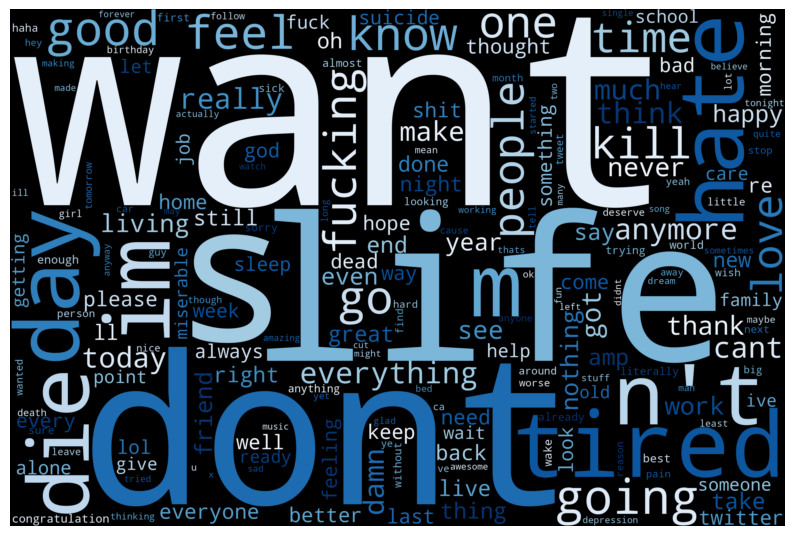

In [37]:
all_words = ' '.join([tweets for tweets in df['Clean_Tweet']])

wordcloud = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap='Blues_r',
    collocations=False,
    stopwords=STOPWORDS
).generate(all_words)

plot_cloud(wordcloud)

In [38]:
data = df.drop("Tweet", axis=1)
data.head()

,Suicide,Clean_Tweet
0,Not Suicide post,making lunch
1,Not Suicide post,want money
2,Potential Suicide post,crap took forever put together im going go sle...
3,Not Suicide post,hey jer since statwittering
4,Not Suicide post,trying quotdelicious library 2quot mixed resul...


In [39]:
# Split data
not_suicide_df = data[data["Suicide"] == "Not Suicide post"]
potential_post_df = data[data["Suicide"] == "Potential Suicide post "]

not_suicide_train, not_suicide_test = train_test_split(not_suicide_df, test_size=0.2, random_state=42)
potential_post_train, potential_post_test = train_test_split(potential_post_df, test_size=0.2, random_state=42)

train = pd.concat([not_suicide_train, potential_post_train])
test = pd.concat([not_suicide_test, potential_post_test])

train_shuffle = shuffle(train, random_state=42)
test_shuffle = shuffle(test, random_state=42)

X_train = train_shuffle["Clean_Tweet"]
y_train = train_shuffle["Suicide"]
X_test = test_shuffle["Clean_Tweet"]
y_test = test_shuffle["Suicide"]

In [40]:
print("X Train data:", X_train.shape[0])
print("y Train data:", y_train.shape[0])
print("=====================")
print("X Test data:", X_test.shape[0])
print("y Test data:", y_test.shape[0])

X Train data: 1421
y Train data: 1421
X Test data: 356
y Test data: 356


In [41]:
# Stopword removal pake sklearn
# Vectorizer TfidfVectorizer CountVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [42]:
joblib.dump(vectorizer, 'vectorizer_temp.pkl')

['vectorizer_temp.pkl']

In [43]:
model = MultinomialNB()
model.fit(X_train_vect, y_train)

MultinomialNB()

In [44]:
y_pred = model.predict(X_test_vect)
y_pred[:5]

array(['Potential Suicide post ', 'Not Suicide post',
       'Potential Suicide post ', 'Not Suicide post', 'Not Suicide post'],
      dtype='<U23')

In [45]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

       Not Suicide post       0.90      0.93      0.92       225
Potential Suicide post        0.88      0.82      0.85       131

               accuracy                           0.89       356
              macro avg       0.89      0.88      0.88       356
           weighted avg       0.89      0.89      0.89       356



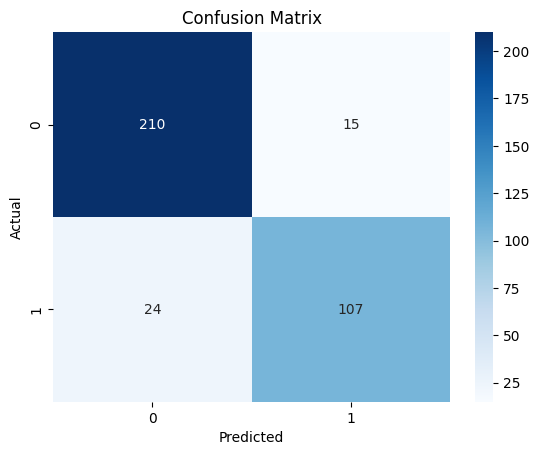

In [46]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
y_pred_train_NB = model.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_NB))

                         precision    recall  f1-score   support

       Not Suicide post       0.98      0.99      0.98       899
Potential Suicide post        0.97      0.97      0.97       522

               accuracy                           0.98      1421
              macro avg       0.98      0.98      0.98      1421
           weighted avg       0.98      0.98      0.98      1421



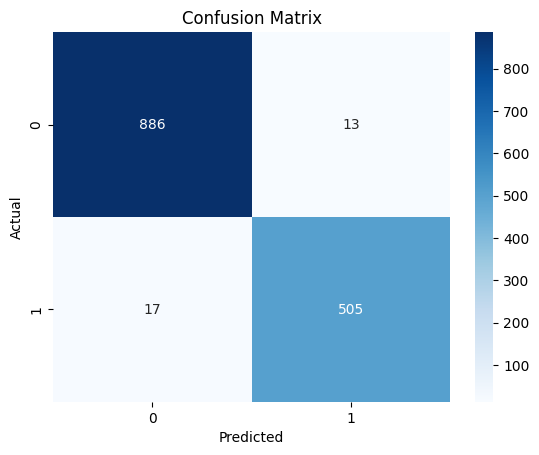

In [48]:
sns.heatmap(confusion_matrix(y_train, y_pred_train_NB), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Hyperparameter tuning untuk alpha
params = {
    'alpha': [0.1, 0.4, 0.54, 0.55, 0.6, 0.65, 1.0, 5.0, 10.0]
}
mnb = MultinomialNB()
grid_search = GridSearchCV(mnb, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best alpha: {'alpha': 0.55}
Best Score: 0.8895305164319248


In [50]:
mnb_tuned = MultinomialNB(**grid_search.best_params_)
mnb_tuned.fit(X_train_vect, y_train)

MultinomialNB(alpha=0.55)

In [51]:
y_pred_tuned_mnb = mnb_tuned.predict(X_test_vect)
print(classification_report(y_test, y_pred_tuned_mnb))

                         precision    recall  f1-score   support

       Not Suicide post       0.90      0.88      0.89       225
Potential Suicide post        0.80      0.84      0.82       131

               accuracy                           0.87       356
              macro avg       0.85      0.86      0.86       356
           weighted avg       0.87      0.87      0.87       356



In [52]:
y_pred_train_tuned_mnb = mnb_tuned.predict(X_train_vect)
print(classification_report(y_train, y_pred_train_tuned_mnb))

                         precision    recall  f1-score   support

       Not Suicide post       0.99      0.98      0.99       899
Potential Suicide post        0.97      0.98      0.98       522

               accuracy                           0.98      1421
              macro avg       0.98      0.98      0.98      1421
           weighted avg       0.98      0.98      0.98      1421



In [ ]:
space = {
    'alpha': (0.1, 5.0)
}

clf = MultinomialNB()

opt = BayesSearchCV(
    clf,
    space,
    n_iter=150,  # Jumlah iterasi
    cv=5,
    scoring='accuracy'
)

opt.fit(X_train_vect, y_train)

# Hyperparameter terbaik
print("Best parameters:", opt.best_params_)